In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [5]:
X_train_vgg16 = vgg16_preprocess(X_train.copy())
X_test_vgg16 = vgg16_preprocess(X_test.copy())

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Redimensiona en tiempo real
    image = vgg16_preprocess(image)  # Normaliza con la función de VGG16
    label = tf.squeeze(tf.one_hot(label, depth=10)) 
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(128).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(128).prefetch(tf.data.AUTOTUNE)


'\ndef preprocess(image, label):\n    #image = tf.image.resize(image, (224, 224))  # Redimensiona en tiempo real\n    image = vgg16_preprocess(image)  # Normaliza con la función de VGG16\n    label = tf.squeeze(tf.one_hot(label, depth=10)) \n    return image, label\n\ntrain_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)    .batch(128).prefetch(tf.data.AUTOTUNE)\n\ntest_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)    .batch(128).prefetch(tf.data.AUTOTUNE)\n'

In [6]:
X_train_resnet50 = resnet50_preprocess(X_train.copy())
X_test_resnet50 = resnet50_preprocess(X_test.copy())

In [7]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [8]:
# Función para construir el modelo con Transfer Learning
def build_model(base_model):
    base_model.trainable = False  # Congelar pesos preentrenados
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(10, activation='softmax')(x)  # CIFAR-10 tiene 10 clases
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Cargar modelos preentrenados sin la parte de clasificación
base_model_vgg16 = VGG16(weights='imagenet',include_top=False, input_shape=(32, 32, 3))
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model_vgg16 = build_model(base_model_vgg16)
model_resnet50 = build_model(base_model_resnet50)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model_vgg16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,769,930 (60.16 MB)

 Trainable params: 1,055,242 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
earlystopping = EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
history_vgg16 = model_vgg16.fit(X_train_vgg16, y_train, epochs=30, batch_size=64, validation_data=(X_test_vgg16, y_test), callbacks=[earlystopping])

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.4316 - loss: 3.3142 - val_accuracy: 0.6046 - val_loss: 1.1934
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5765 - loss: 1.2285 - val_accuracy: 0.6247 - val_loss: 1.0928
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6178 - loss: 1.1095 - val_accuracy: 0.6469 - val_loss: 1.0281
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6335 - loss: 1.0564 - val_accuracy: 0.6524 - val_loss: 1.0266
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6449 - loss: 1.0256 - val_accuracy: 0.6574 - val_loss: 0.9993
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6576 - loss: 0.9959 - val_accuracy: 0.6707 - val_loss: 0.9870
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6647 - loss: 0.9766 - val_accuracy: 0.6643 - val_loss: 0.9941
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6737 - loss: 0.9465 - val_acc

In [ ]:
print(history_vgg16.history.keys())

In [ ]:
model_resnet50.summary()

In [13]:
history_resnet50 = model_resnet50.fit(X_train_resnet50, y_train, epochs=30, batch_size=64, validation_data=(X_test_resnet50, y_test),callbacks=[earlystopping])

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.4788 - loss: 1.8080 - val_accuracy: 0.6268 - val_loss: 1.1173
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6022 - loss: 1.1406 - val_accuracy: 0.6383 - val_loss: 1.0422
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6316 - loss: 1.0670 - val_accuracy: 0.6533 - val_loss: 1.0183
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6423 - loss: 1.0214 - val_accuracy: 0.6524 - val_loss: 1.0138
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6591 - loss: 0.9787 - val_accuracy: 0.6633 - val_loss: 0.9892


In [14]:
# Evaluación de modelos
score_vgg16 = model_vgg16.evaluate(X_test_vgg16, y_test)
score_resnet50 = model_resnet50.evaluate(X_test_resnet50, y_test)
#score_inception = model_inception.evaluate(X_test_resized, y_test)

print(f"VGG16 - Loss: {score_vgg16[0]:.4f}, Accuracy: {score_vgg16[1]:.4f}")
print(f"ResNet50 - Loss: {score_resnet50[0]:.4f}, Accuracy: {score_resnet50[1]:.4f}")
#print(f"InceptionV3 - Loss: {score_inception[0]:.4f}, Accuracy: {score_inception[1]:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6862 - loss: 0.9549
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6196 - loss: 1.1167
VGG16 - Loss: 0.9616, Accuracy: 0.6835
ResNet50 - Loss: 1.1173, Accuracy: 0.6268


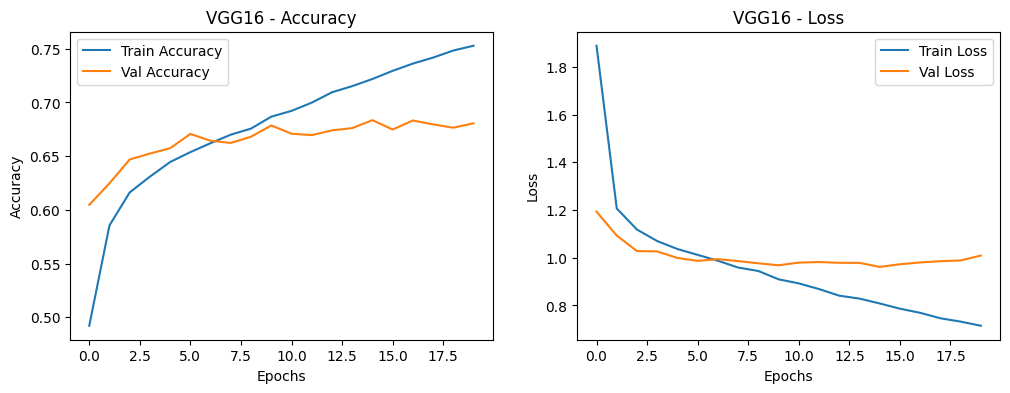

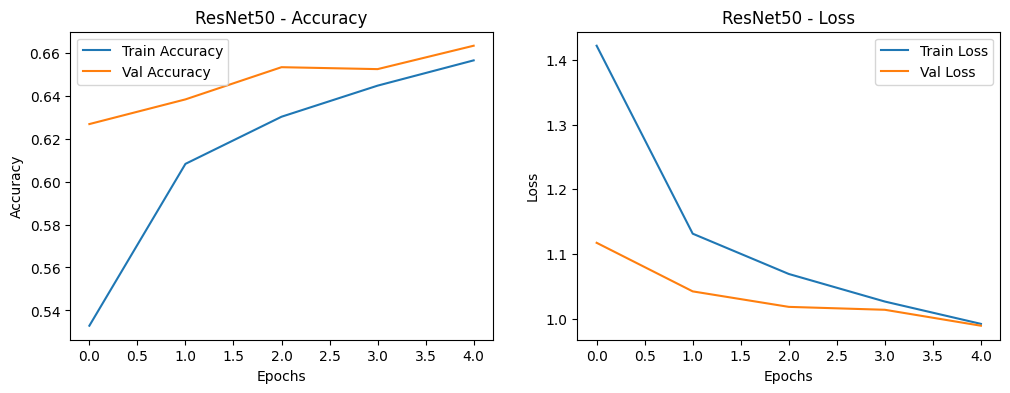

In [15]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_vgg16, 'VGG16')
plot_history(history_resnet50, 'ResNet50')
#plot_history(history_inception, 'InceptionV3')


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Classification Report for VGG16:

              precision    recall  f1-score   support

           0       0.69      0.79      0.73      1000
           1       0.79      0.77      0.78      1000
           2       0.70      0.50      0.58      1000
           3       0.49      0.61      0.54      1000
           4       0.59      0.66      0.63      1000
           5       0.70      0.54      0.61      1000
           6       0.66      0.80      0.72      1000
           7       0.76      0.69      0.72      1000
           8       0.77      0.79      0.78      1000
           9       0.77      0.70      0.73      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



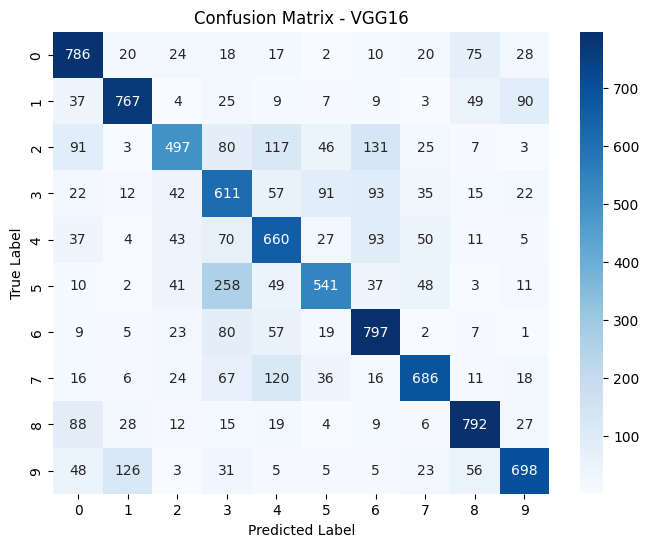

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
Classification Report for ResNet50:

              precision    recall  f1-score   support

           0       0.70      0.60      0.65      1000
           1       0.66      0.72      0.69      1000
           2       0.67      0.43      0.52      1000
           3       0.50      0.41      0.45      1000
           4       0.56      0.61      0.59      1000
           5       0.59      0.59      0.59      1000
           6       0.57      0.82      0.67      1000
           7       0.69      0.64      0.66      1000
           8       0.71      0.73      0.72      1000
           9       0.65      0.73      0.69      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.62     10000
weighted avg       0.63      0.63      0.62     10000



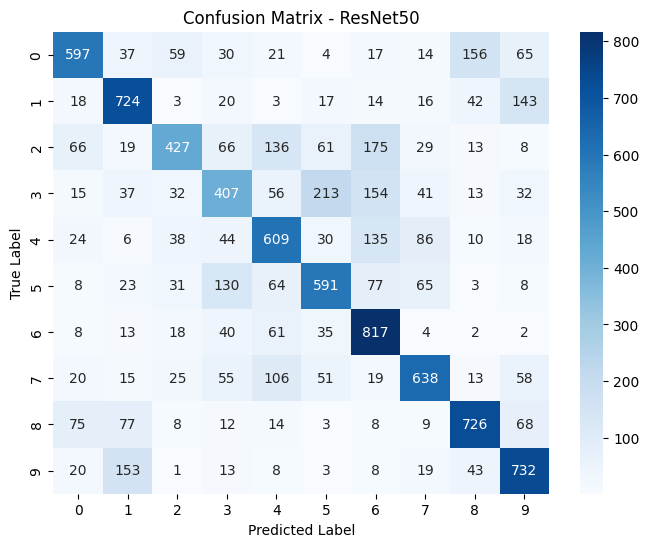

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
    y_true = tf.argmax(y_test, axis=1).numpy()

    print(f'Classification Report for {model_name}:\n')
    print(classification_report(y_true, y_pred_classes))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

evaluate_model(model_vgg16, X_test_vgg16, y_test, 'VGG16')
evaluate_model(model_resnet50, X_test_resnet50, y_test, 'ResNet50')
